In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

In [214]:
data = pd.read_excel('241.xlsx')
data.columns = pd.MultiIndex.from_tuples([
    ("Up", "T"),
    ("Up", "h"),
    ("Up", "H"),
    ("Up", "dh"),
    ("Down", "T"),
    ("Down", "h"),
    ("Down", "H"),
    ("Down", "dh"),
])

data[('Up', 'dh')]   = 10 * data[('Up', 'dh')]
data[('Down', 'dh')] = 10 * data[('Down', 'dh')]

In [215]:
data.head()

Up                     Down                   
    T     h     H    dh      T     h      H    dh
0  22  6.14  7.57  14.3  50.00  2.80  11.57  87.7
1  24  6.09  7.98  18.9  47.70  3.19  11.12  79.3
2  26  5.96  8.13  21.7  46.00  3.54  10.75  72.1
3  28  5.80  8.31  25.1  43.91  3.86  10.39  65.3
4  30  5.66  8.47  28.1  42.00  4.16  10.06  59.0

In [216]:
class dataset:
    def __init__(self, data, sigma):
        self.data  = data
        self.sigma = sigma

In [217]:
class relation:    
    def __init__(self, x, y, ignore = ()):
        self.x = x
        self.y = y
        self.ignore = ignore
        
    def ignored(self):
        return [np.take(self.x.data, self.ignore), np.take(self.y.data, self.ignore)]
    
    def clean(self):
        return [np.delete(self.x.data, self.ignore), np.delete(self.y.data, self.ignore)]
        

In [218]:
read = lambda name: np.array(data[name].dropna(), dtype=np.double)
Tup = read(('Up', 'T'))

up = relation(x = dataset(read(('Up', 'T')),         np.full(Tup.size, 0.5,  dtype=np.double)),    \
              y = dataset(read(('Up', 'dh')),   np.full(Tup.size, 0.02, dtype=np.double)))

dw = relation(x = dataset(np.flip(read(('Down', 'T'))),       np.full(Tup.size, 0.5,  dtype=np.double)),    \
              y = dataset(np.flip(read(('Down', 'dh'))), np.full(Tup.size, 0.02, dtype=np.double)))


## Графики P(T)

In [219]:
names = {
            'T' : r"$T, \footnotesize ^{\circ} C$",
            'H' : r"$H, \text{\footnotesize cм}$",
            'h' : r"$h, \text{\footnotesize cм}$",
            'dh' : r"$P, \text{\footnotesize мм рт. ст.}$",
            'Up' : 'Нагрев',
            'Down' : 'Охлаждение',
        }

data_fmt = { 
    (names['Up'], names['T']) : "{:.1f}",
    (names['Up'], names['H']) : "{:.2f}",
    (names['Up'], names['h']) : "{:.2f}",
    (names['Up'], names['dh']) : "{:.2f}",
    (names['Down'], names['T']) : "{:.1f}",
    (names['Down'], names['H']) : "{:.2f}",
    (names['Down'], names['h']) : "{:.2f}",
    (names['Down'], names['dh']) : "{:.2f}",
}

latex = data[2:].rename(
        columns=(names)
    ).style.hide(level=0, axis=0).format(data_fmt).to_latex(
        buf     = 'Данные.tex',
        label   = 'tab:data',
        caption = 'Данные',
        column_format="c" * 8 ,
        position_float = 'centering',
        hrules=True,
        multicol_align = 'c',
    )




print(latex)
data

None


Up                      Down                   
     T     h      H    dh      T     h      H    dh
0   22  6.14   7.57  14.3  50.00  2.80  11.57  87.7
1   24  6.09   7.98  18.9  47.70  3.19  11.12  79.3
2   26  5.96   8.13  21.7  46.00  3.54  10.75  72.1
3   28  5.80   8.31  25.1  43.91  3.86  10.39  65.3
4   30  5.66   8.47  28.1  42.00  4.16  10.06  59.0
5   32  5.49   8.65  31.6  40.00  4.46   9.74  52.8
6   34  5.27   8.88  36.1  38.00  4.74   9.46  47.2
7   36  5.05   9.14  40.9  36.00  4.96   9.23  42.7
8   38  4.82   9.40  45.8  34.00  5.17   8.97  38.0
9   40  4.56   9.68  51.2  32.00  5.38   8.79  34.1
10  42  4.27  10.00  57.3  30.00  5.56   8.56  30.0
11  44  3.94  10.33  63.9  28.00  5.72   8.39  26.7
12  46  3.59  10.68  70.9  26.00  5.86   8.23  23.7
13  48  3.22  11.10  78.8  24.00  5.96   8.12  21.6
14  50  2.80  11.57  87.7  22.00  6.09   7.93  18.4

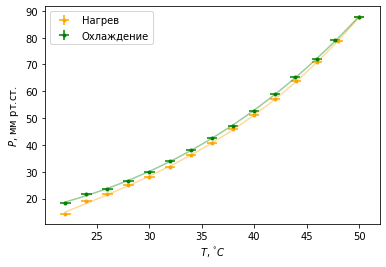

In [220]:
plt.ylabel(r"$P$, мм рт.ст.")
plt.xlabel(r"$T$, $^{\degree}C$")

plt.errorbar(up.x.data, up.y.data, yerr=up.y.sigma, xerr=up.x.sigma, fmt='.', label='Нагрев',     c='orange') 
plt.errorbar(dw.x.data, dw.y.data, yerr=dw.y.sigma, xerr=dw.x.sigma, fmt='.', label='Охлаждение', c='green') 


t   = np.linspace(22, 50, 100)

spl = UnivariateSpline(up.x.data, up.y.data, s=10)
plt.plot(t, spl(t), alpha=0.4, c='orange')

spl = UnivariateSpline(dw.x.data, dw.y.data)
plt.plot(t, spl(t), alpha=0.4, c='green')

plt.legend()
plt.savefig("P(T).pdf")

## Способ P(T)


In [221]:
class series:
    p = 0
    T = 0
    x = 0
    y = 0
    dpdT = 0
    ignore = 0

In [222]:
up = series()
up.p = np.array(data[('Up', 'dh')], dtype=np.double)
up.T = np.array(data[('Up', 'T')], dtype=np.double) + 273.15


up.dpdT = (np.delete(np.roll(up.p, -1), up.p.size - 1) - np.delete(up.p, up.p.size - 1)) \
        / (np.delete(np.roll(up.T, -1), up.T.size - 1) - np.delete(up.T, up.T.size - 1)) 

up.x = up.p[:up.p.size - 1]/(up.T[:up.T.size - 1])**2
up.y = up.dpdT


dw = series()
dw.p = np.array(data[('Down', 'dh')], dtype=np.double)
dw.T = np.array(data[('Down', 'T')], dtype=np.double) + 273.15


dw.dpdT = (np.delete(np.roll(dw.p, -1), dw.p.size - 1) - np.delete(dw.p, dw.p.size - 1)) \
        / (np.delete(np.roll(dw.T, -1), dw.T.size - 1) - np.delete(dw.T, dw.T.size - 1)) 

dw.x = dw.p[:dw.p.size - 1]/(dw.T[:dw.T.size - 1])**2
dw.y = dw.dpdT

out = pd.DataFrame({'dPdTup' : up.y, 'PTup' : up.x, 'dPdTdw' : dw.y, 'PTdw' : dw.x})

out.columns = pd.MultiIndex.from_tuples([
    ("Up", "dPdT"),
    ("Up", "PT"),
    ("Down", "dPdT"),
    ("Down", "PT"),
])

names = {
            'dPdT' : r"$\frac{dP}{dT}$",
            'PT' : r"$\frac{P}{T^2}$",
            'Up' : 'Нагрев',
            'Down' : 'Охлаждение',
        }

out_fmt = { 
    (names['Up'], names['dPdT']) : "{:.3f}",
    (names['Up'], names['PT']) : "{:.5f}",
    (names['Down'], names['dPdT']) : "{:.3f}",
    (names['Down'], names['PT']) : "{:.5f}",
} 

latex = out.rename(
        columns=(names)
    ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
        buf     = 'Линеаризация2.tex',
        label   = 'tab:linear2',
        caption = r'Линеаризация  $\frac{dP}{dT}(\frac{P}{T^2})$',
        column_format="c" * 4 ,
        position_float = 'centering',
        hrules=True,
        multicol_align = 'c',
        environment = r'subtable',
        #position_float = '{0.48\textwidth}'
    )

a_file = open("Линеаризация2.tex", "r")
list_of_lines = a_file.readlines()
list_of_lines[0] = r'\begin{subtable}{0.48\textwidth}'

a_file = open("Линеаризация2.tex", "w")
a_file.writelines(list_of_lines)
a_file.close()


In [223]:
up.ignore = (0)
dw.ignore = ()

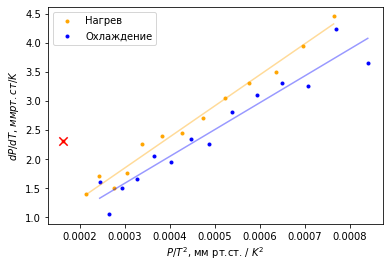

In [224]:
plt.scatter(up.x, up.y, label='Нагрев', marker='.', c='orange')
plt.scatter(np.take(up.x, up.ignore), np.take(up.y, up.ignore), s=70, marker='x', c='r')

plt.scatter(dw.x, dw.y, label='Охлаждение', marker='.', c='blue')
plt.scatter(np.take(dw.x, dw.ignore), np.take(dw.y, dw.ignore), s=70, marker='x', c='r')


p = np.polyfit(np.delete(up.x, ignore), np.delete(up.y, up.ignore), 1)
pol = lambda x: p[0]*x + p[1]
t = np.linspace(np.delete(up.x, up.ignore).min(), np.delete(up.x, up.ignore).max(), 100)
plt.plot(t, pol(t), c='orange', alpha=0.4)

p = np.polyfit(np.delete(dw.x, dw.ignore), np.delete(dw.y, dw.ignore), 1)
pol = lambda x: p[0]*x + p[1]
t = np.linspace(np.delete(dw.x, dw.ignore).min(), np.delete(dw.x, dw.ignore).max(), 100)
plt.plot(t, pol(t), c='blue', alpha=0.4)


plt.xlabel(r"$P/T^2$, мм рт.ст. / $K^2$")
plt.ylabel(r"$dP/dT$, $мм рт. ст / K$")
plt.legend()
plt.savefig('dPdT.pdf')

In [225]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

In [228]:
df, dat = mnk(np.delete(up.x, up.ignore), np.delete(up.y, up.ignore))
df
latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
4.51e-04 & 2.94e-08 & 2.65 & 8.54e-01 & 1.57e-04 & 5342.85 & 211.66 & 0.24 & 0.10 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.000451,2.939645e-08,2.646154,0.853639,0.000157,5342.852239,211.655058,0.23919,0.102023


In [229]:
df, dat = mnk(np.delete(dw.x, dw.ignore), np.delete(dw.y, dw.ignore))
df
latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
4.95e-04 & 3.48e-08 & 2.48 & 8.01e-01 & 1.61e-04 & 4620.80 & 371.61 & 0.19 & 0.20 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.000495,3.481348e-08,2.481392,0.801021,0.000161,4620.802019,371.607997,0.192885,0.196671


In [232]:
8.314 * 5342.852 / 0.0180152 * 0.03961

97667.2408424042

In [231]:
211.65/5342.852239

0.03961367272242095

In [236]:
8.314 * 4620.802019/ 0.0180152

2132496.3356480086

In [234]:
371.607997 / 4620.802019

0.08042067058316009

## Способ 1/T ln(P)

In [189]:
def mnk(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [190]:
cup   = copy.deepcopy(up)
cup.x = dataset(1/(cup.x.data + 273.15), up.x.sigma/(up.x.data+273.15)**2)
cup.y = dataset(np.log(cup.y.data), up.y.sigma/(up.y.data))

cdw   = copy.deepcopy(dw)
cdw.x = dataset(1/(cdw.x.data + 273.15), dw.x.sigma/(dw.x.data+273.15)**2)
cdw.y = dataset(np.log(cdw.y.data), dw.y.sigma/(dw.y.data))

out = pd.DataFrame({'lnpup' : cup.y.data, '1/Tup' : cup.x.data, 'lnpdw' : cdw.y.data, '1/Tdw' : cdw.x.data})

out.columns = pd.MultiIndex.from_tuples([
    ("Up", "lnp"),
    ("Up", "1/T"),
    ("Down", "lnp"),
    ("Down", "1/T"),
])

names = {
            'lnp' : r"$\ln{P}$",
            '1/T' : r"$\frac{1}{T}, \text{\footnotesize К}$",
            'Up' : 'Нагрев',
            'Down' : 'Охлаждение',
        }

out_fmt = { 
    (names['Up'], names['lnp']) : "{:.3f}",
    (names['Up'], names['1/T']) : "{:.4f}",
    (names['Down'], names['lnp']) : "{:.3f}",
    (names['Down'], names['1/T']) : "{:.4f}",
} 

latex = out.rename(
        columns=(names)
    ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
        buf     = 'Линеаризация.tex',
        label   = 'tab:linear',
        caption = 'Линеаризация',
        column_format="c" * 4 ,
        position_float = 'centering',
        hrules=True,
        multicol_align = 'c',
        environment = r'subtable',
    )

a_file = open("Линеаризация.tex", "r")
list_of_lines = a_file.readlines()
list_of_lines[0] = r'\begin{subtable}{0.48\textwidth}'

a_file = open("Линеаризация.tex", "w")
a_file.writelines(list_of_lines)
a_file.close()


out

Up                Down          
         lnp       1/T       lnp       1/T
0   2.660260  0.003388  2.912351  0.003388
1   2.939162  0.003365  3.072693  0.003365
2   3.077312  0.003343  3.165475  0.003343
3   3.222868  0.003321  3.284664  0.003321
4   3.335770  0.003299  3.401197  0.003299
5   3.453157  0.003277  3.529297  0.003277
6   3.586293  0.003256  3.637586  0.003256
7   3.711130  0.003235  3.754199  0.003235
8   3.824284  0.003214  3.854394  0.003214
9   3.935740  0.003193  3.966511  0.003193
10  4.048301  0.003173  4.077537  0.003173
11  4.157319  0.003153  4.178992  0.003154
12  4.261270  0.003133  4.278054  0.003133
13  4.366913  0.003114  4.373238  0.003117
14  4.473922  0.003095  4.473922  0.003095

In [199]:
cup.ignore = (0)

[-5637.27784208    21.93065783]
[-5302.52118882    20.89737489]


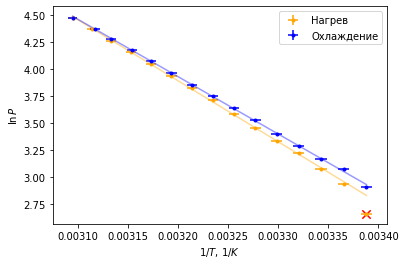

In [200]:
plt.ylabel(r"$\ln{P}$")
plt.xlabel(r"$1/T$, $1/K$")

#plt.scatter(cup.x.data, cup.y.data, marker='*', s=10, c='orange', label='Нагрев')
plt.errorbar(cup.x.data, cup.y.data, xerr=cup.x.sigma, yerr=cup.x.sigma, c='orange', label='Нагрев', fmt='.')
plt.scatter(cup.ignored()[0], cup.ignored()[1], s=70, marker='x', c='r')


#plt.scatter(cdw.x.data, cdw.y.data, marker='*', s=10, c='blue',   label='Охлаждение')
plt.errorbar(cdw.x.data, cdw.y.data, xerr=cdw.x.sigma, yerr=cdw.x.sigma, c='blue',   label='Охлаждение', fmt='.')
plt.scatter(cdw.ignored()[0], cdw.ignored()[1], s=70, marker='x', c='r')

p = np.polyfit(cup.clean()[0], cup.clean()[1], 1)
pol = lambda x: p[0]*x + p[1]
t = np.linspace(cup.x.data.min(), cup.x.data.max(), 100)
plt.plot(t, pol(t), c='orange', alpha=0.4)
print(p)

p = np.polyfit(cdw.clean()[0], cdw.clean()[1], 1)
pol = lambda x: p[0]*x + p[1]
t = np.linspace(cdw.x.data.min(), cdw.x.data.max(), 100)
plt.plot(t, pol(t), c='blue', alpha=0.4)
print(p)

plt.legend()
plt.savefig('lnP(T).pdf')

In [201]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.003226,7.045434e-09,3.742389,0.223999,-0.00004,-5637.277842,34.918772,21.930658,0.112701


In [208]:
df, dat = mnk(cup.clean()[0], cup.clean()[1])
df

latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.23e-03 & 7.05e-09 & 3.74 & 2.24e-01 & -3.97e-05 & -5637.28 & 34.92 & 21.93 & 0.11 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.003226,7.045434e-09,3.742389,0.223999,-0.00004,-5637.277842,34.918772,21.930658,0.112701


In [206]:
df, dat = mnk(cdw.clean()[0], cdw.clean()[1])


latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.24e-03 & 8.14e-09 & 3.73 & 2.29e-01 & -4.32e-05 & -5302.52 & 29.12 & 20.90 & 0.09 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.003237,8.144868e-09,3.730674,0.229097,-0.000043,-5302.521189,29.122469,20.897375,0.094319


In [197]:
-8.314 * -5637.27784208 / 0.0180152 * 0.005492192857317406

14288.483955824253

In [210]:
-8.314 * -5302.52118882 / 0.0180152

2447109.1724682203

In [211]:
(29.122469/-5302.521189)

-0.005492192857317406

In [209]:
-8.314 * -5637.277842 / 0.0180152

2601599.092898664

In [212]:
0.0054921 * 2447109.17

13439.768272557